# Pipeline de Machine Learning

In [1]:
import sys

sys.path.append("../src")

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import processing
import seaborn as sns
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, PowerTransformer
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm

sns.set(style="darkgrid")
tqdm.pandas()

/tmp/ipykernel_176704/4021271184.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Carregamento dos Dados

Para oo modelo de machine learning, vamos utilizar a mesma divisão treino/teste utilizada na análise de dados:

In [3]:
DATA_PATH = "../_data/dataset_2021-5-26-10-14.csv"


def load_data():
    data = pd.read_csv(DATA_PATH, sep="\t", encoding="utf8", na_values="missing")
    train, test = train_test_split(
        data, test_size=0.2, stratify=data["default"], shuffle=True, random_state=0
    )
    return train, test


train, test = load_data()
X_train = train.drop("default", axis=1)
y_train = train["default"]
X_test = test.drop("default", axis=1)
y_test = test["default"]

## Pré-processamento

Para facilitar a utilização do modelo de predição posteriormente, o preprocessamento será realizado utilizando transformers e pipelines. Para permitir o uso do pickle para carregar o modelo em outros arquivos, as funções dos tranformers foram implementadas no arquivo [processing.py](../src/processing.py). As próximas células apenas exibem o código utilizado.

O pré-processamento realizado é justificado pelas descobertas feitas durante a análise de dados.

### Correção de pares de variáveis de quantidade/valor

Primeiramente, vamos corrigir os erros nos seguintes pares de variáveis.

- `quant_protestos` e `valor_protestos`
- `dividas_vencidas_qtd` e `dividas_vencidas_valor`
- `quant_acao_judicial` e `acao_judicial_valor`

Para todos os pares, existem casos em que a quantidade é zero, mas o valor não é zero. Isso indica que a quantidade está errada, de forma que será substituída por NaN.

```py
def fix_amount(data: pd.DataFrame) -> pd.DataFrame:
    pairs = [
        ("quant_protestos", "valor_protestos"),
        ("dividas_vencidas_qtd", "dividas_vencidas_valor"),
        ("quant_acao_judicial", "acao_judicial_valor"),
    ]

    data = data.copy()
    for amount_col, value_col in pairs:
        if amount_col in data.columns and value_col in data.columns:
            invalid = (data[amount_col] == 0) & (data[value_col] != 0)
            data.loc[invalid, amount_col] = np.nan
    return data
```

### Correção da distribuição

Dada a assimetria elevada na distribuição dos dados, vou aplicar um power transform nas features numéricas ara aproximar a sua distribuição de uma distribuição normal. Isso será feito a partir do `PowerTransformer`.

Obs: essa transformação não será aplicada para os modelos baseados em árvores, visto que eles não dependem da distribuição dos dados.

### Forma de pagamento

A conversão da forma de pagamento utiliza a mesma função descrita no notebook de análise de dados.

### Adição da feature qtd_indicadores_zero

A contagem da quantidade de indicadores zero é feita com o seguinte código:

```py
def count_zeros(data: pd.DataFrame, zero_cols: list[str]) -> pd.DataFrame:
    # A variável é repetida aqui para garantir que essa o pickle funcione corretamente
    return pd.DataFrame({"qtd_indicadores_zero": data.loc[:, zero_cols].sum(axis=1)})
```

### Conversão para tipo categórico

Para facilitar a interação com os modelos de predição, vou converter as colunas categórias para o tipo "category" do pandas.

```py
def to_category(data: pd.DataFrame) -> pd.DataFrame:
    return data.astype("category")
```

Para alguns classificadores, será necessário codificar as variáveis categóricas em forma numérica. Como não há uma ordenação natural entre as categorias, vou utilizar one-hot encoding, com o `OneHotEncoder`.

### Transformador completo

Abaixo, aplicamos as transformações descritas acima. As colunas utilizadas para criar o `qtd_indicadores_zero` são extremamente desbalanceadas e são retiradas.

São criados três tranformadores:
- Um transformador que corrige as variáveis de quantidade. Esse transformador precisa ser aplicado antes do cálculo do número de indicadores zero.
- Um transformador com as outras transformações comuns a todos os modelos (processamento da coluna de forma de pagamento, criação do indicador de zeros, conversão para categoria)
- Um transformador específico para modelos que não tem suporte nativo a features categoricas e dependem da distribuição dos dados (inclui one-hot encoding, power transform e imputação)

Os primeiros dois transformadores não tem estado, então podem ser reutilizados. Já o tranformador específico tem estado, e logo deve ser recriado para cada modelo diferente.

In [4]:
preprocessing_common1 = make_column_transformer(
    (
        FunctionTransformer(processing.fix_amount),
        [
            "quant_protestos",
            "valor_protestos",
            "dividas_vencidas_qtd",
            "dividas_vencidas_valor",
            "quant_acao_judicial",
            "acao_judicial_valor",
        ],
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)
preprocessing_common2 = make_column_transformer(
    (FunctionTransformer(processing.convert_payment_column), ["forma_pagamento"]),
    (FunctionTransformer(processing.count_zeros), processing.zero_cols),
    (
        # Como as colunas abaixo já foram utilizadas para calcular
        # qtd_indicadores_zero, por padrão, elas seria removidas do dataset.
        # Esse item adicional garante que elas não serão removidas
        "passthrough",
        [
            "quant_protestos",
            "valor_protestos",
            "dividas_vencidas_qtd",
            "dividas_vencidas_valor",
            "quant_acao_judicial",
            "acao_judicial_valor",
        ],
    ),
    (
        FunctionTransformer(processing.to_category),
        ["tipo_sociedade", "opcao_tributaria", "atividade_principal"],
    ),
    (FunctionTransformer(processing.drop_column), ["participacao_falencia_valor"]),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

preprocessing_common1.set_output(transform="pandas")
preprocessing_common2.set_output(transform="pandas")


def make_specific_preprocessing_transformer():
    t1 = make_column_transformer(
        (PowerTransformer(), make_column_selector(dtype_include=np.number)),
        (
            OneHotEncoder(
                handle_unknown="infrequent_if_exist",
                min_frequency=0.01,
            ),
            make_column_selector(dtype_include=pd.Categorical),
        ),
    )
    t2 = SimpleImputer(strategy="mean")
    transformer = make_pipeline(t1, t2)
    transformer.set_output(transform="pandas")
    return transformer

In [5]:
X_train_proc = preprocessing_common1.fit_transform(X_train)
X_train_proc = preprocessing_common2.fit_transform(X_train_proc)

print(X_train_proc.shape)
X_train_proc.head()

(93818, 21)


,primeira_parcela,ultima_parcela,qtd_parcelas,is_boleto,qtd_indicadores_zero,quant_protestos,valor_protestos,dividas_vencidas_qtd,dividas_vencidas_valor,quant_acao_judicial,...,tipo_sociedade,opcao_tributaria,atividade_principal,ioi_36months,ioi_3months,valor_por_vencer,valor_quitado,valor_total_pedido,month,year
85316,28.0,42.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,sociedade empresaria limitada,simples nacional,com de eletrodomesticos,133.000000,17.941883,0.00,90755.55,28342.406159,8,2019
94814,30.0,90.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,empresario (individual),simples nacional,com de telefones e equip p/ comunicacoes,272.000000,18.245173,10310.86,0.00,3773.144153,6,2018
91803,30.0,90.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,empresario (individual),simples nacional,com de confeccoes em geral,72.666667,63.000000,4688.11,37810.92,2392.068367,9,2017
64498,42.0,70.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,empresa individual respons limitada empresaria,simples nacional,papelaria,107.033333,10.201515,0.00,19604.76,2220.607501,4,2017
40607,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,empresario (individual),simples nacional,com de equipamentos de informatica,14.411765,11.833333,2844.28,124477.15,1510.317835,10,2017


Após o preprocessamento, temos 15 variáveis.

## Comparação de alguns modelos

Aqui, vou comparar dois modelos mais simples (regressão logística e SVM) com o LightGBM. O objetivo é validar a necessidade de um modelo mais complexo.

Para a comparação, a métrica utilizada será a precisão média (**AP** ou Average Precision). Como o meu objetivo é escolher um threshold ótimo para o modelo após a obtenção de um modelo final, quero uma métrica que não dependa de um threshold específico. Escolhi a precisão média, AP, (que é também a área sob a curva de precisão vs. recall) ao invés de ROC AUC, pois ela produz valores mais úteis para o nosso contexto. Um dos benefícios do AUC é a sua independência da distribuição de dados. No nosso caso, isso é um ponto negativo.

Por exemplo, consideremos um modelo com FPR=0.1 e TPR=0.9. Se a proporção de default na população diminuir, haverá mais instâncias negativas e, logo, mais falso positivos. Cada falso positivo corresponde a dinheiro perdido (um pedido rejeitado pela X-Health). A precisão é capaz de capturar essa variação, mas o TPR/FPR (utilizados pelo AUC) permanecem constantes.

In [6]:
model_linear = make_pipeline(
    preprocessing_common1,
    preprocessing_common2,
    make_specific_preprocessing_transformer(),
    LogisticRegression(max_iter=1_000, class_weight="balanced", random_state=0),
)

# Para o SVM, utilizo o Nystroem+LinearSVC, que é melhor adaptado
# para grandes quantidades de dados
model_svm = make_pipeline(
    preprocessing_common1,
    preprocessing_common2,
    make_specific_preprocessing_transformer(),
    Nystroem("rbf", random_state=0),
    LinearSVC(class_weight="balanced", dual=False, random_state=0),
)

model_lgbm = make_pipeline(
    preprocessing_common1,
    preprocessing_common2,
    LGBMClassifier(verbose=-1, is_unbalance=True, random_state=0),
)

In [7]:
scores = cross_val_score(
    model_linear, X_train, y_train, scoring="average_precision", cv=5, n_jobs=-1
)
print(f"[Regressão Logística] AP = {scores.mean():.3}")

scores = cross_val_score(
    model_svm, X_train, y_train, scoring="average_precision", cv=5, n_jobs=-1
)
print(f"[SVM] AP = {scores.mean():.3}")

scores = cross_val_score(
    model_lgbm, X_train, y_train, scoring="average_precision", cv=5
)
print(f"[LGBM] AP = {scores.mean():.3}")

[Regressão Logística] AP = 0.422
[SVM] AP = 0.432
[LGBM] AP = 0.74


## Seleção de Features

Para a seleção de features, vamos utilizar a importância de features calculada pelo LightGBM (que consiste no número de splits do qual cada feature participa). A importância das features calculada nos dados de treino pode ser vista abaixo.

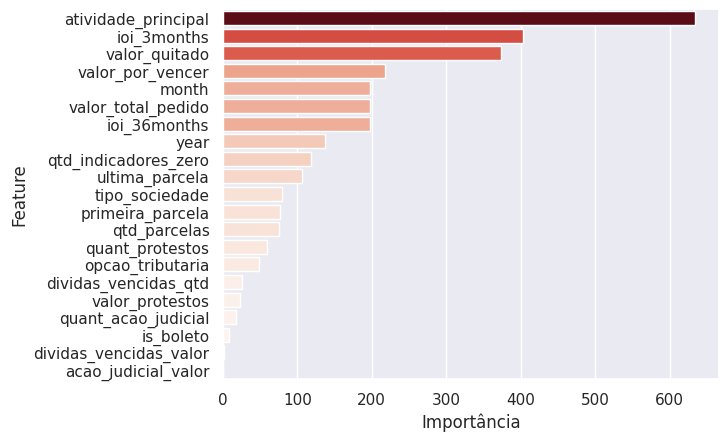

In [8]:
model_lgbm.fit(X_train, y_train)
clf = model_lgbm.named_steps["lgbmclassifier"]
results = pd.DataFrame(
    {
        "feature": clf.feature_name_,
        "importance": clf.feature_importances_,
    }
)
results = results.sort_values("importance", ascending=False)
ax = sns.barplot(
    x="importance",
    y="feature",
    hue="importance",
    data=results,
    palette="Reds",
)
plt.xlabel("Importância")
plt.ylabel("Feature")
ax.get_legend().remove()

O gráfico deixa claro que `atividade_principal` é a feature mais importante, com uma grande margem. Além disso, várias das features tem importância baixa.

A estratégia utilizada para selecionar as features será Recursive Feature Elimination, ou seja, vamos começar com todas as features e iterativamente:
1. Avaliar o modelo utilizando validação cruzada
2. Calcular a importância das features
3. Remover a feature menos importante


In [9]:
# O código a seguir cumpre a mesma tarefa que a classe RFECV do sklearn,
# mas o RFECV não suporta dados categóricos.

features = results["feature"].tolist()
scores_per_iter = {}
features_per_iter = {}
for num_features in range(len(results), 0, -1):
    print(f"{num_features=:2d}  ", end="", flush=True)

    # Avalia o modelo com um subset das features
    scores = cross_val_score(
        clf, X_train_proc[features], y_train, scoring="average_precision", cv=5
    )
    scores_per_iter[num_features] = scores.mean()
    features_per_iter[num_features] = features.copy()

    # Re-treina o modelo em todos os dados de treino e elimina a pior feature
    clf.fit(X_train_proc[features], y_train)
    worst_feature = clf.feature_name_[np.argmin(clf.feature_importances_)]
    features.remove(worst_feature)

    print(f"AP={scores.mean():.4f}  ->  feature removida: {worst_feature}")

num_features=21  

AP=0.7403  ->  feature removida: acao_judicial_valor
num_features=20  AP=0.7412  ->  feature removida: dividas_vencidas_valor
num_features=19  AP=0.7400  ->  feature removida: is_boleto
num_features=18  AP=0.7388  ->  feature removida: quant_acao_judicial
num_features=17  AP=0.7402  ->  feature removida: valor_protestos
num_features=16  AP=0.7388  ->  feature removida: dividas_vencidas_qtd
num_features=15  AP=0.7385  ->  feature removida: opcao_tributaria
num_features=14  AP=0.7322  ->  feature removida: primeira_parcela
num_features=13  AP=0.7323  ->  feature removida: quant_protestos
num_features=12  AP=0.7201  ->  feature removida: qtd_parcelas
num_features=11  AP=0.7193  ->  feature removida: tipo_sociedade
num_features=10  AP=0.7111  ->  feature removida: qtd_indicadores_zero
num_features= 9  AP=0.6745  ->  feature removida: year
num_features= 8  AP=0.6393  ->  feature removida: valor_total_pedido
num_features= 7  AP=0.6305  ->  feature removida: ultima_parcela
num_features= 6  AP

A partir dos resultados, vemos que até 15 features, alguma melhoria do modelo pode ser observada. A partir de 16 features, o score do modelo oscila em torno do mesmo valor.

In [10]:
best_features = features_per_iter[15]
print("Features selectionadas:", *best_features, sep="\n - ")

Features selectionadas:
 - atividade_principal
 - ioi_3months
 - valor_quitado
 - valor_por_vencer
 - month
 - valor_total_pedido
 - ioi_36months
 - year
 - qtd_indicadores_zero
 - ultima_parcela
 - tipo_sociedade
 - primeira_parcela
 - qtd_parcelas
 - quant_protestos
 - opcao_tributaria


## Otimização de Hiperparâmetros

In [11]:
def objective(trial: optuna.Trial) -> float:
    """Avalia um modelo LGBM"""
    params = {
        "verbose": -1,
        "random_state": 0,
        "is_unbalance": trial.suggest_categorical("is_unbalance", [False, True]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "boosting": trial.suggest_categorical("boosting", ["gbdt", "dart"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**6),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
    }
    clf = LGBMClassifier(**params)
    scores = cross_val_score(
        clf, X_train_proc[best_features], y_train, scoring="average_precision", cv=3
    )
    return np.mean(scores)


sampler = TPESampler(multivariate=True, seed=0)
study = optuna.create_study(
    study_name="lightgbm",
    storage="sqlite:///optuna_lightgbm.db",
    load_if_exists=True,
    direction="maximize",
    sampler=sampler,
)
# study.optimize(objective, n_trials=100)

/home/fernando/.local/share/virtualenvs/solution-jgGq5V3l/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-02-09 01:24:24,752] Using an existing study with name 'lightgbm' instead of creating a new one.


In [12]:
optuna.visualization.plot_param_importances(study)

In [13]:
study.best_value, study.best_params

(0.8412244397109675,
 {'is_unbalance': False,
  'learning_rate': 0.3747067251453826,
  'n_estimators': 289,
  'boosting': 'gbdt',
  'lambda_l1': 6.133770089625727e-08,
  'lambda_l2': 2.1815578194588485,
  'num_leaves': 54,
  'min_data_in_leaf': 10})

## Escolha de Threshold

In [14]:
X_thresh_train, X_thresh_val, y_thresh_train, y_thresh_val = train_test_split(
    X_train_proc, y_train, test_size=0.2, random_state=0, stratify=y_train
)

clf = LGBMClassifier(verbose=-1, random_state=0, **study.best_params)
clf.fit(X_thresh_train[best_features], y_thresh_train)

LGBMClassifier(boosting='gbdt', is_unbalance=False,
               lambda_l1=6.133770089625727e-08, lambda_l2=2.1815578194588485,
               learning_rate=0.3747067251453826, min_data_in_leaf=10,
               n_estimators=289, num_leaves=54, random_state=0, verbose=-1)

0.3092249345825002


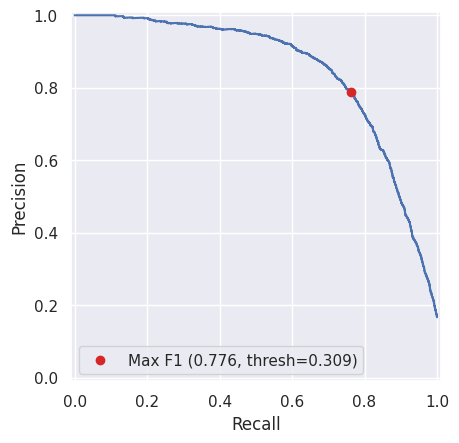

In [15]:
precision, recall, thresholds = precision_recall_curve(
    y_thresh_val, clf.predict_proba(X_thresh_val[best_features])[:, 1]
)
f1 = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1)

PrecisionRecallDisplay(precision, recall).plot()
plt.scatter(
    recall[best_idx],
    precision[best_idx],
    c="tab:red",
    zorder=100,
    label=f"Max F1 ({f1[best_idx]:.3f}, thresh={thresholds[best_idx]:.3f})",
)
plt.legend()
print(thresholds[best_idx])

## Treinamento e Armazenamento do Modelo Final

Considerando as features e hiperparâmetros selecionados, criamos um pipeline que opera desde o dataset inicial. Como a feature `qtd_indicadores_zero` está sendo utilizado, é necessário incluir todas as features utilizadas no seu cálculo. Isso significa que a única feature não utilizada é `participacao_falencia_valor`.

In [16]:
input_features = [
    # Features selecionadas anteriormente, exceto as derivas de outras features
    "atividade_principal",
    "ioi_3months",
    "valor_quitado",
    "valor_por_vencer",
    "month",
    "valor_total_pedido",
    "ioi_36months",
    "year",
    "tipo_sociedade",
    "quant_protestos",
    "opcao_tributaria",
    # Features necessárias para o cálculo de outras features
    "forma_pagamento",
    "valor_vencido",
    "default_3months",
    "valor_protestos",
    "quant_acao_judicial",
    "dividas_vencidas_valor",
    "dividas_vencidas_qtd",
    "acao_judicial_valor",
    "falencia_concordata_qtd",
]
params = {
    "is_unbalance": False,
    "learning_rate": 0.3747067251453826,
    "n_estimators": 289,
    "boosting": "gbdt",
    "lambda_l1": 6.133770089625727e-08,
    "lambda_l2": 2.1815578194588485,
    "num_leaves": 54,
    "min_data_in_leaf": 10,
}
threshold = 0.3092249345825002

print("Features não utilizadas:", set(X_train.columns) - set(input_features))

Features não utilizadas: {'participacao_falencia_valor'}


In [17]:
preprocessing_part1 = make_column_transformer(
    (
        FunctionTransformer(processing.fix_amount),
        [
            "quant_protestos",
            "valor_protestos",
            "dividas_vencidas_qtd",
            "dividas_vencidas_valor",
            "quant_acao_judicial",
            "acao_judicial_valor",
        ],
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)
preprocessing_part2 = make_column_transformer(
    (FunctionTransformer(processing.convert_payment_column), ["forma_pagamento"]),
    (FunctionTransformer(processing.count_zeros), processing.zero_cols),
    (
        FunctionTransformer(processing.to_category),
        ["tipo_sociedade", "opcao_tributaria", "atividade_principal"],
    ),
    (
        # Features que não precisam ser processadas
        "passthrough",
        [
            "ioi_3months",
            "valor_quitado",
            "valor_por_vencer",
            "month",
            "valor_total_pedido",
            "ioi_36months",
            "year",
            "quant_protestos",
        ],
    ),
    remainder="drop",
    verbose_feature_names_out=False,
)

preprocessing_part1.set_output(transform="pandas")
preprocessing_part2.set_output(transform="pandas")

final_model = make_pipeline(
    preprocessing_part1,
    preprocessing_part2,
    LGBMClassifier(verbose=-1, random_state=0, **params),
)

In [18]:
final_model.fit(X_train[input_features], y_train)

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer',
                                                  FunctionTransformer(func=<function fix_amount at 0x7080655e5090>),
                                                  ['quant_protestos',
                                                   'valor_protestos',
                                                   'dividas_vencidas_qtd',
                                                   'dividas_vencidas_valor',
                                                   'quant_acao_judicial',
                                                   'acao_judicial_valor'])],
                                   verbose_feature_names_out=False)),
                ('c...
                                                   'valor_por_vencer', 'month',
                                                   'valor_total_pedido',
                                                   'ioi_36months', 'year',
                                                   'quant_protestos'])],
                                   verbose_feature_names_out=False)),
                ('lgbmclassifier',
                 LGBMClassifier(boosting='gbdt', is_unbalance=False,
                                lambda_l1=6.133770089625727e-08,
                                lambda_l2=2.1815578194588485,
                                learning_rate=0.3747067251453826,
                                min_data_in_leaf=10, n_estimators=289,
                                num_leaves=54, random_state=0, verbose=-1))])

In [19]:
model_data = {
    "model": final_model,
    "threshold": threshold,
    "input_features": input_features,
}
with open("../model.pickle", "wb") as f:
    pickle.dump(model_data, f)

## Avaliação do Modelo Final


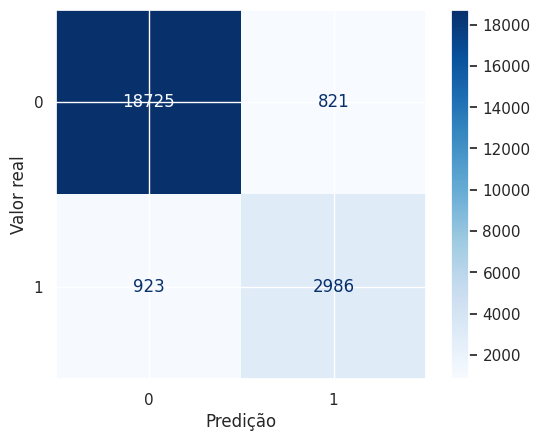

In [20]:
y_pred_proba = final_model.predict_proba(X_test[input_features])[:, 1]
y_pred = (y_pred_proba > threshold).astype(np.int64)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.xlabel("Predição")
plt.ylabel("Valor real")
plt.show()

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

tp_mask = (y_test == 1) & (y_pred == 1)
fp_mask = (y_test == 0) & (y_pred == 1)

profit_margin = 0.2

# perdas evitadas pelo modelo
avoided_losses = X_test.loc[tp_mask, "valor_total_pedido"].sum()

# perdas evitadas, ignorando lucros (ie, incluindo apenas o custo de produção)
avoided_losses_discounted = avoided_losses * (1 - profit_margin)

# perdas causadas pelo modelo
incurred_losses = X_test.loc[fp_mask, "valor_total_pedido"].sum()

# perdas causadas, considerando apenas o lucro
incurred_losses_discounted = profit_margin * incurred_losses


avoided_losses = round(avoided_losses, 2)
avoided_losses_discounted = round(avoided_losses_discounted, 2)
incurred_losses = round(incurred_losses, 2)
incurred_losses_discounted = round(incurred_losses_discounted, 2)

# Lucro líquido
net = avoided_losses_discounted - incurred_losses_discounted

# Lucro liquido estimado para todos os dados
net_projected = net * (len(train) + len(test)) / len(test)


print(f"Acurácia: {accuracy:.3}")
print(f"Precisão: {precision:.3}")
print(f"Recall: {recall:.3}")
print(f"F1: {f1:.3}")
print(f"Transações corretamente evitadas pelo modelo: R$ {avoided_losses:,.2f} (TP)")
print(f"Transações incorretamente evitadas pelo modelo: R$ {incurred_losses:,.2f} (FP)")
print("Considerando uma margem de lucro de 20%:")
print(f"  Perdas evitadas pelo modelo: R$ {avoided_losses_discounted:,.2f}")
print(f"  Perdas causadas pelo modelo: R$ {incurred_losses_discounted:,.2f}")
print(f"  Líquido: R$ {net:,.2f}")
print(f"  Líquido (estimativa incluindo dados de treino): R$ {net_projected:,.2f}")

Acurácia: 0.926
Precisão: 0.784
Recall: 0.764
F1: 0.774
Transações corretamente evitadas pelo modelo: R$ 59,686,821.22 (TP)
Transações incorretamente evitadas pelo modelo: R$ 14,657,695.56 (FP)
Considerando uma margem de lucro de 20%:
  Perdas evitadas pelo modelo: R$ 47,749,456.97
  Perdas causadas pelo modelo: R$ 2,931,539.11
  Líquido: R$ 44,817,917.86
  Líquido (estimativa incluindo dados de treino): R$ 224,085,767.69


No contexto de predição de default, verdadeiros positivos permitem que um default seja evitado, enquanto falso positivos fazem com que transações boas sejam erroneamente deixadas de lado. Supondo uma margem de lucro de 20%, podemos calcular uma economia líquida de 45 milhões de reais devido ao modelo. Esses cálculos foram realizados na base de teste (20% dos dados), de forma que no dataset inteiro, podemos estimar uma economia líquida de 5x, ou seja, R$ 224 milhões.

A margem de lucro de 20% é utilizada da seguinte forma:
- Um pedido com default causa uma perda de 80% do seu valor total, ou seja, a perda é igual ao custo de produção
- Um pedido sem default causa um lucro de 20% do seu valor total

Essa análise ignora o potencial da X-Health de conseguir novos contratos para substituir os contratos rejeitados. Caso isso seja possível (ie, caso a X-Health rejeite pedidos devido à uma falta de capacidade), o lucro devido ao modelo seria ainda maior.